In [1]:
import sys
import SimpleITK as sitk
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline 

import numpy as np
from numpy import array, zeros_like
from scipy.ndimage import zoom

import os
import fnmatch
import shutil
from ipywidgets import interact, fixed
import pandas as pd
from pathlib import Path

from skimage import data
from skimage import color
from skimage import img_as_float
from skimage import exposure
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.transform import rotate

from scipy.ndimage import rotate as rotate_nd

from PIL import Image

import cv2

#parallel computing packages
from numba import jit
import psutil
from multiprocess import Pool



#function for showing volume images
def myshow(image_arr,slice_n):
    plt.imshow(image_arr[slice_n,:,:],cmap='gray')
    plt.show()

In [2]:
df=pd.read_pickle('/mnt/e/Image Processing/Brats Project/train.pkl')

### deleting first 10 of empty images and last 10 empty images of volume 

In [3]:
@jit
def redo(data, col):
    for i,y in enumerate(data[col]):
        data.at[i, col] = y[10:140, :, :].astype('uint8')
        print('{} DONE!'.format(i))

redo(df, 'pseudo')
redo(df, 'seg')

0 DONE!
1 DONE!
2 DONE!
3 DONE!
4 DONE!
5 DONE!
6 DONE!
7 DONE!
8 DONE!
9 DONE!
10 DONE!
11 DONE!
12 DONE!
13 DONE!
14 DONE!
15 DONE!
16 DONE!
17 DONE!
18 DONE!
19 DONE!
20 DONE!
21 DONE!
22 DONE!
23 DONE!
24 DONE!
25 DONE!
26 DONE!
27 DONE!
28 DONE!
29 DONE!
30 DONE!
31 DONE!
32 DONE!
33 DONE!
34 DONE!
35 DONE!
36 DONE!
37 DONE!
38 DONE!
39 DONE!
40 DONE!
41 DONE!
42 DONE!
43 DONE!
44 DONE!
45 DONE!
46 DONE!
47 DONE!
48 DONE!
49 DONE!
50 DONE!
51 DONE!
52 DONE!
53 DONE!
54 DONE!
55 DONE!
56 DONE!
57 DONE!
58 DONE!
59 DONE!
60 DONE!
61 DONE!
62 DONE!
63 DONE!
64 DONE!
65 DONE!
66 DONE!
67 DONE!
68 DONE!
69 DONE!
70 DONE!
71 DONE!
72 DONE!
73 DONE!
74 DONE!
75 DONE!
76 DONE!
77 DONE!
78 DONE!
79 DONE!
80 DONE!
81 DONE!
82 DONE!
83 DONE!
84 DONE!
85 DONE!
86 DONE!
87 DONE!
88 DONE!
89 DONE!
90 DONE!
91 DONE!
92 DONE!
93 DONE!
94 DONE!
95 DONE!
96 DONE!
97 DONE!
98 DONE!
99 DONE!
100 DONE!
101 DONE!
102 DONE!
103 DONE!
104 DONE!
105 DONE!
106 DONE!
107 DONE!
108 DONE!
109 DONE!
110 DONE!


In [4]:
df.seg[0].dtype

dtype('uint8')

### Splitting volumes into separate volumes and creating new dataframe for each image

In [5]:
#function construct array of images  and labels
@jit
def go_and_construct_array(data, size_x, size_y, col=['pseudo', 'seg']):
    
    x=np.empty(size_x, dtype='uint8')
    y=np.empty(size_y, dtype='uint8')
    
    counter_x=0 #use this for indexing of future array
    counter_y=0
    
    for index, volume in enumerate(data.loc[:, col[0]]):
        for i, sl in enumerate(volume):
        
            x[counter_x] = sl
            counter_x += 1 
            #print('{} {} out of {} DONE!'.format(col[0], counter_x, 285*130))
            
    for index, volume in enumerate(data.loc[:, col[1]]):
        for i, sl in enumerate(volume):
            y[counter_y]=sl
            counter_y += 1
            #print('{} {} out of {} DONE!'.format(col[1], counter_y, 285*130))
    return x,y #returning two arrays x with images and y with labels 

In [6]:
X, Y  = go_and_construct_array(df, size_x=(130*285, 240, 240, 3), size_y=(130*285, 240, 240))

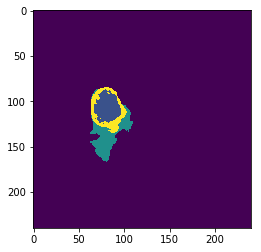

In [7]:
plt.imshow(Y[60])

In [8]:
X.shape

(37050, 240, 240, 3)

### Downsapling

In [91]:
#downsampling to reduce computational costs
@jit
def rapid_resize(array, size=(37050, 120, 120, 3)):
    
    new_array=np.empty(size, dtype='uint8')
    counter=0
    for index, image in enumerate(array):
        new_array[counter]=image[::2, ::2]
        counter +=1
    
    return new_array

#applying
X_array = rapid_resize(X)
Y_array = rapid_resize(Y, size=(37050, 120, 120))

### New Df for further processing

In [9]:
@jit
def create_df(images, labels, columns=['X', 'Y']):
    
    data=pd.DataFrame([], columns=['X', 'Y'], index=range(0,37050))
    
    counter_images=0
    counter_labels=0
    
    for index, image in enumerate(images):
        data.at[counter_images, columns[0]] = image
        counter_images += 1
    
    for index, image in enumerate(labels):
        data.at[counter_labels, columns[1]] = image
        counter_labels += 1
    
    return data





In [11]:
#applying previous funciton to create dataframe from our arrays
final_df = create_df(X, Y).copy()

In [ ]:
final_df.to_pickle('./final_pickle.pkl') #creating final df